<a href="https://colab.research.google.com/github/RR77ui/Business-Intelligence/blob/main/Integracion%20de%20datos/Parcial2_JuanRave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Caso de Estudio**
Una FINTECH quiere estimar las perdidas asociadas con el riesgo derivado de los fallos tecnologicos en transacciones de sus clientes atraves de sus canales electronicos, para esto cuenta con una base de datos que cuenta con las variables transacciones fallidas y valor generado promedio que son las variables que tomaremos como frecuencia y severidad para obtener la distribucion agregada de perdida, perdidas esperadas, perdidas no esperadas, perdidas catastroficas, matriz de perdidas y matriz de eventos para poder evidenciar la gestion y el riesgo operacional de la empresa

0. Carga de las librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def KMedoids(X):

  #Se configura el modelo K-Medoids
  XC=np.zeros((5,1))
  XC[:,0]=np.sort(np.random.uniform(low=np.min(X), high=np.max(X), size=5))

  for k in range(len(X)):
      nff=np.argmin(np.abs(XC[:,0]-X[k]))
      XC[nff,0]=(XC[nff,0]+X[k])/2

  XC=np.sort(XC)

  #Se procede con la configuración de la base de xcada cluster
  sigma=np.zeros((5,1))

  for k in range(5):
      sigma[k,0]=np.sum(np.abs(XC[:,]-XC[k,]))/4


  return XC,sigma

1. Inspeccion de los datos

In [4]:
XDB = pd.read_excel('/content/drive/MyDrive/Integración de datos y prospectiva/5. FallasTecnológicas.xlsx')
# Primera fila pasa a ser nombre de las columnas
XDB.columns = XDB.iloc[0]

# drop de la primera fila
XDB = XDB[1:].reset_index(drop=True)

print(XDB.shape)
print(XDB.info())
XDB.head()

(701, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Fechas                              701 non-null    object
 1   Transacciones Diarias               701 non-null    object
 2   Valor Transado (millones)           701 non-null    object
 3   Transacciones Fallidas              701 non-null    object
 4   Valor Generado Promedio (Millones)  701 non-null    object
 5   Descripción Evento                  701 non-null    object
dtypes: object(6)
memory usage: 33.0+ KB
None


,Fechas,Transacciones Diarias,Valor Transado (millones),Transacciones Fallidas,Valor Generado Promedio (Millones),Descripción Evento
0,2009-01-01 00:00:00,80,14.8058,1,0.5374,"Errores visuales menores, problemas de usabili..."
1,2009-01-02 00:00:00,105,56.4721,4,1.1978,"Errores en la interfaz de usuario, fallas en f..."
2,2009-01-03 00:00:00,70,9.976,5,0.4269,"Errores visuales menores, problemas de usabili..."
3,2009-01-04 00:00:00,105,18.2949,6,1.0814,"Errores en la interfaz de usuario, fallas en f..."
4,2009-01-05 00:00:00,130,23.4112,7,1.2105,"Errores en la interfaz de usuario, fallas en f..."


2. LDA Distribucion de Perdidas agregradas

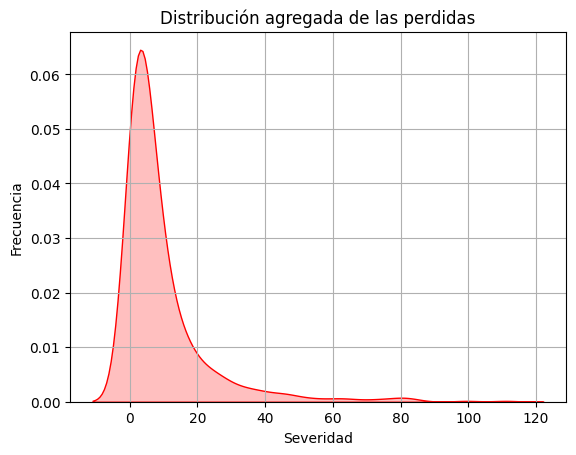

El costo de aseguramiento de las transacciones fallidas es de:
102902100


,Media,Varianza,Asimetría,OpVar,NPE,NPNE,NPC
0,9.451113,13.707472,3.34836,102.9021,502.0,198.0,1.0


In [5]:
#Convertir las columnas en valores numericos
XDB['Transacciones Fallidas'] = pd.to_numeric(XDB['Transacciones Fallidas'], errors='coerce')
XDB['Valor Generado Promedio (Millones)'] = pd.to_numeric(XDB['Valor Generado Promedio (Millones)'], errors='coerce')

Xf=np.array(XDB.iloc[:,3])  #Frecuencia
Xs=np.array(XDB.iloc[:,4])  #Severidad
Xr=np.array(XDB.iloc[:,5])  #Tipo de falla
LDA=Xf*Xs

plt.figure()
sns.kdeplot(LDA,fill=True,color='red')
plt.xlabel('Severidad')
plt.ylabel('Frecuencia')
plt.title('Distribución agregada de las perdidas')
plt.grid()
plt.show()

#Se crea el vector para la presentación de resultados
pr=[]
#Parametros del Riesgo
pr.append(np.mean(LDA))
pr.append(np.std(LDA))
pr.append(skew(LDA))
#Pérdidas Esperadas - Cuantos pérdidas hay por debajo de la media
NPE=len(LDA[LDA<np.mean(LDA),])
#Cuantos hay por encima del OpVar
OpVar=np.percentile(LDA,99.9)
pr.append(OpVar)
print("El costo de aseguramiento de las transacciones fallidas es de:")
print(f"{OpVar*1000000:.0f}")
NPC=len(LDA[LDA>OpVar,])
#Cuantas son las pérdidas no esperadas
NPNE=len(LDA)-NPE-NPC
pr.append(NPE)
pr.append(NPNE)
pr.append(NPC)
pr=np.array(pr).reshape(1,7)
df2=pd.DataFrame((pr))
df2.columns = ["Media","Varianza","Asimetría","OpVar","NPE","NPNE","NPC"]
display(df2)

3. Matriz de perdidas

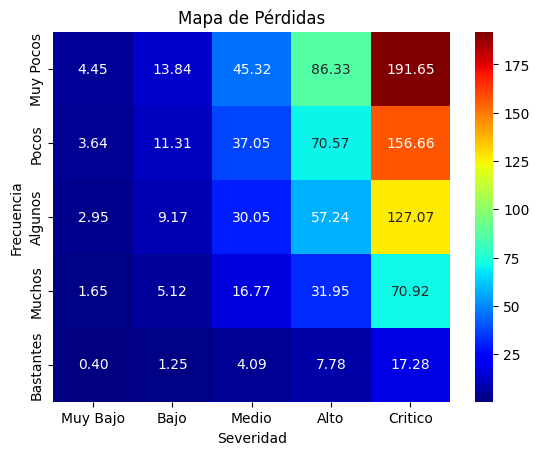

Los cluster para la frecuencia son:
['Muy Pocos', 'Pocos', 'Algunos', 'Muchos', 'Bastantes']
[[ 1.07267262  4.40324251  7.88916867  9.72687543 11.89905183]]
Los cluster para la severidad son:
['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Critico']
[[ 0.37394726  1.16281852  3.80911117  7.25507449 16.10639724]]


In [6]:
#Modelamos la variable de Frecuencia - KMedoids
np.random.seed(42)
XCf=np.array(XDB.iloc[:,3])
X=XCf
XCf,sigmaf=KMedoids(X)
lbf=['Muy Pocos','Pocos','Algunos','Muchos','Bastantes']

#Modelamos la variable de Severidad
XCs=np.array(XDB.iloc[:,4])
X=XCs
XCs,sigmas=KMedoids(X)
lbs=['Muy Bajo','Bajo','Medio','Alto','Critico']

#Modelamos el mapa de pérdida
MP=np.outer(XCf,XCs)
MPo=MP[::-1,:]  #Quedaron ordenados


#Mapeo bidimensional de las perdidas
plt.figure()
sns.heatmap(MPo,annot=True,cmap='jet',fmt='.2f')
plt.xlabel('Severidad')
plt.xticks(np.arange(len(lbs))+0.5,lbs)
plt.ylabel('Frecuencia')
plt.yticks(np.arange(len(lbf))+0.5,lbf)
plt.title('Mapa de Pérdidas')
plt.show()

print('Los cluster para la frecuencia son:')
print(lbf)
print(XCf.transpose())
print('Los cluster para la severidad son:')
print(lbs)
print(XCs.transpose())

4. Matriz de eventos

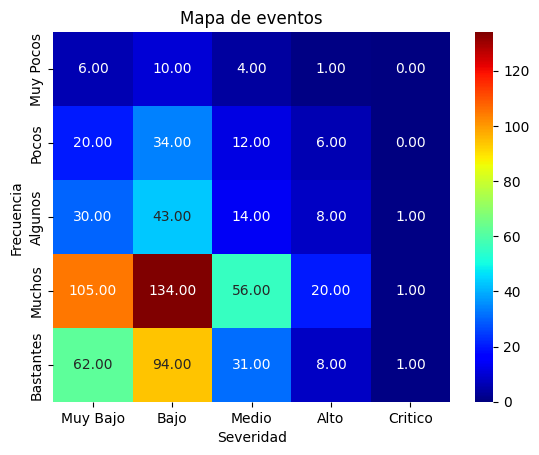

In [7]:
Mf=np.zeros((5,5,))

#Contenedores en tierra por cada cuadrito
XDf=np.array(XDB.iloc[:,3]); XDs=np.array(XDB.iloc[:,4])

for k in range(len(XDf)):
  nff=np.argmin(np.abs(XCf[:,0]-XDf[k]))
  nfs=np.argmin(np.abs(XCs[:,0]-XDs[k]))
  Mf[nff,nfs]+=1

#Eventos de pérdida por celda
Mfo=Mf[::-1,:]
#lbfo=lbf[::-1]  #Labels ordenados

plt.figure()
sns.heatmap(Mfo,annot=True,cmap='jet',fmt='.2f')
plt.xlabel('Severidad')
plt.xticks(np.arange(len(lbs))+0.5,lbs)
plt.ylabel('Frecuencia')
plt.yticks(np.arange(len(lbf))+0.5,lbf)
plt.title('Mapa de eventos')
plt.show()

4. Matriz de impacto

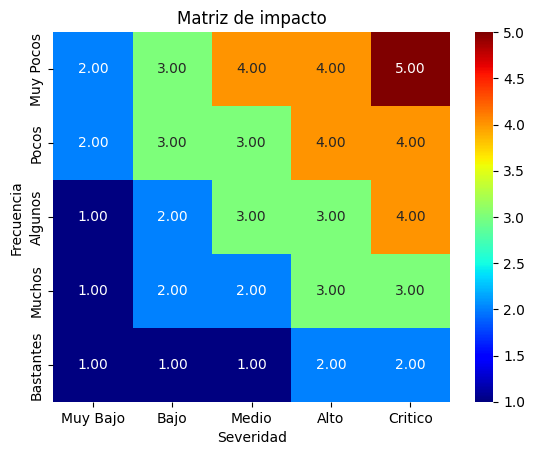

,Frecuencia,ClusterFrecuencia,Severidad,ClusterSeveridad,Impacto
0,1.0,0.0,0.5374,0.0,0.5374
1,4.0,1.0,1.1978,1.0,4.7912
2,5.0,1.0,0.4269,0.0,2.1345
3,6.0,1.0,1.0814,1.0,6.4884
4,7.0,2.0,1.2105,1.0,8.4735
...,...,...,...,...,...
696,1.0,0.0,0.5747,0.0,0.5747
697,6.0,1.0,0.7209,0.0,4.3254
698,10.0,3.0,0.3628,0.0,3.6280
699,4.0,1.0,0.2715,0.0,1.0860


In [8]:
#Matriz de impacto cuales son los cuadros con mayor impacto para las finanzas de la organizacion
#Donde se tiene que tener una mayor enfasis en los riesgos
MI=np.zeros((5,5))
MI=np.array([[1,1,1,2,2],
     [1,2,2,3,3],
     [1,2,3,3,4],
     [2,3,3,4,4],
     [2,3,4,4,5],])
MIo=MI[::-1,:]

plt.figure()
sns.heatmap(MIo,annot=True,cmap='jet',fmt='.2f')
plt.xlabel('Severidad')
plt.xticks(np.arange(len(lbs))+0.5,lbs)
plt.ylabel('Frecuencia')
plt.yticks(np.arange(len(lbf))+0.5,lbf)
plt.title('Matriz de impacto')
plt.show()

#Se clasifican los datos por cluster en frecuencia y en severidad
#Se saca el valor minimo porque es el dato mas cercano a cada cluster, en otras palabras es la distancia del numero hacia el cluster mientras sea menor mas cerca esta
Xf=np.array(XDB.iloc[:,3])  #Frecuencia
Xs=np.array(XDB.iloc[:,4])  #Severidad
ncf=np.zeros((len(Xf),1)) #Que cluster es?
ncs=np.zeros((len(Xs),1)) #Que cluster es?
for k in range(len(Xf)):
  ncf[k]=np.argmin(np.abs(XCf-Xf[k]))
  ncs[k]=np.argmin(np.abs(XCs-Xs[k]))

tabla=np.column_stack((Xf,ncf,Xs,ncs,Xf*Xs))
df=pd.DataFrame(tabla)
df.columns = ["Frecuencia","ClusterFrecuencia","Severidad","ClusterSeveridad","Impacto"]
display(df)
df.to_excel('ClustersAnalysis_ft.xlsx')

5. Cuanto es el valor de las perdidas que se ubican en las celdas 2 y 3 de la matriz de eventos

In [9]:
# Definimos los indices de los clusters
target_freq_index = 3
target_sev_index = 2

# Filtramos los valores correspondientes a los indices que queremos buscar
Perdidas = df[(df['ClusterFrecuencia'] == target_freq_index) & (df['ClusterSeveridad'] == target_sev_index)]

# Realizamos la sumatoria de las perdidas de los eventos en la celda 2,3
total_perdidas = Perdidas['Impacto'].sum()

print(f"La suma total de pérdidas para los eventos en la celda (2,3) es: {total_perdidas*1000000:.0f}")

La suma total de pérdidas para los eventos en la celda (2,3) es: 423357900


In [14]:
target_freq_index = 3
target_sev_index = 2

# Filtramos los valores correspondientes a los indices que queremos buscar
Perdidas = df[(df['ClusterFrecuencia'] == target_freq_index) & (df['ClusterSeveridad'] == target_sev_index)]

# Pegamos al dataframe la descripcion del evento
Perdidas = Perdidas.join(XDB['Descripción Evento'])

# Mostrar el dataframe
print(f"Los eventos ubicados en la celda (2,3) son:")
display(Perdidas)

Los eventos ubicados en la celda (2,3) son:


,Frecuencia,ClusterFrecuencia,Severidad,ClusterSeveridad,Impacto,Descripción Evento
16,9.0,3.0,3.2730,2.0,29.4570,"Degradación del rendimiento por varias horas, ..."
89,10.0,3.0,4.2795,2.0,42.7950,"Degradación del rendimiento por varias horas, ..."
246,9.0,3.0,4.5547,2.0,40.9923,"Degradación del rendimiento por varias horas, ..."
258,10.0,3.0,3.5493,2.0,35.4930,"Degradación del rendimiento por varias horas, ..."
328,9.0,3.0,3.5130,2.0,31.6170,"Degradación del rendimiento por varias horas, ..."
438,10.0,3.0,2.4863,2.0,24.8630,"Degradación del rendimiento por varias horas, ..."
454,9.0,3.0,5.0553,2.0,45.4977,Degradación severa del rendimiento por más de ...
523,10.0,3.0,3.9165,2.0,39.1650,"Degradación del rendimiento por varias horas, ..."
543,10.0,3.0,4.4854,2.0,44.8540,"Degradación del rendimiento por varias horas, ..."
562,9.0,3.0,4.4385,2.0,39.9465,"Degradación del rendimiento por varias horas, ..."


##**Analisis de Resultados**
1. Analizando la LDA se encuentra que la distribucion tiene un sesgo positivo y una cola larga hacia la derecha y la cual muestra un mayor concentracion de perdidas entre 0 y 20 millones de dolares ademas se encontraron los siguienten valors para el numero de perdidas y medidas de tendencia central:
Media: 9.45
Varianza: 13.70
Asimetria: 3.34
Perdidas Esperadas: 502
Perdidas no esperadas: 198
Perdidas Catastroficas: 1
OPvar: 1029021

2. Como se puede evidenciar en la matriz de perdidas y matriz de eventos la mayoria de los eventos de fallas tecnologicas se ubicaron entre la severidad muy baja y media representando una frecuencia alta pero con bajo costo he impacto para la compañia teniendo en cuenta la clasificion en ambas tablas y lo cual concuerda con la distribucion de perdidas previamente explicada

3. Se querian obtener los eventos que se ubicaban en la celda 2,3 lo cual dio como resultado 12 eventos donde el riesgo que mas se repite en esta celda es la degradación del rendimiento por varias horas, interrupción temporal de servicios clave, pérdida de datos parcial, incidentes de seguridad que afectan a un número considerable de clientes, errores en la interfaz de usuario que impiden realizar transacciones, este tipo de eventos constituye para la compañia un riesgo alto con perdidas de decenas de millones a cientos de millones de dolares para este caso se debe llevar una gestion moderada que con las siguientes acciones: Gestión de cambios rigurosa, pruebas de carga regulares, implementación de sistemas de detección de anomalías, análisis de riesgos continuo, capacitación del personal en gestión de riesgos. Esta acciones son las que estan demarcadas por la empresa para los eventos que ocurren con esta severidad y frecuencia